In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import scipy.stats as stats

%matplotlib inline
plt.style.use('seaborn-colorblind')

### Reading in Relevant Dataset

In [2]:

#2005-2015: Reading in mulitple excels because they don't contain all the years
old_2006_2009 = pd.read_excel('data/2006_2009.xls', skiprows=range(3)) #<-- 2005,2007,2008,2009
load_2006 = pd.read_excel('data/2006.xls', skiprows = range(6)) #<-- 2006
sat_1995_2015 = pd.read_excel('data/SAT_1995_2015.xls', skiprows=range(3)) #<-- 2010, 2013, 2014
load_2011_2012 = pd.read_excel('data/2010-2012.xls', skiprows=range(5)) #<-- 2011, 2012
load_2015 = pd.read_excel('data/2015.xls', skiprows=range(5)) #<-- 2015

sat_1987_1998 = pd.read_excel('data/SAT_1987_1998.xls', skiprows=range(11)) #Currently not using
sat_2017_2018 = pd.read_excel('data/SAT_2017_2018.xls', skiprows=range(5)) #Currently not using

#Remove unwanted rows and columns
sat_2017 = sat_2017_2018.iloc[:-3, :8]
sat_2018 = sat_2017_2018.iloc[:-3, 8:]

### Old SAT format: 2400 score. Lasted from 2005-2015

In [3]:
#Helper functions


#Get the clean list of states from the DF.
def clean_states(df:pd.DataFrame) -> list:
    states_list = []
    for i in df.iloc[:, 0]:
        states_list.append(i.split('.')[0])
        
    return states_list

#Cleaning up data and split the DF into respective years if applicable
def clean_multi_dataset(df, renamed_col = ['State', 'Reading', 'Math', 'Writing']):
    for i in range(1, len(df.columns) - 1, 3):
        data_year = df.iloc[:,i:i+3]

        data_year.insert(0, 'States', clean_states(df))
        data_year.columns = renamed_col
        data_year['SAT Total Score'] = data_year.apply(lambda row: row.Reading + row.Math + row.Writing, axis=1)

        yield data_year
    
#For df that only contain 1 year needed:
def clean_dataset(df, start, end, renamed_col = ['State', 'Reading', 'Math', 'Writing']):
    data_year = df.iloc[:, start:end]

    data_year.insert(0, 'States', clean_states(df))
    data_year.columns = renamed_col
    data_year['SAT Total Score'] = data_year.apply(lambda row: row.Reading + row.Math + row.Writing, axis=1)

    return data_year

In [4]:
#Clean table of NaN rows and columns and nonuseful data.
def remove_nan(df):
    return df[pd.notnull(df.iloc[:,1])]

In [5]:
#Cleaning data of NaN values
#Ready for splitting and filtering

#For 2006
data_2006 = remove_nan(load_2006)

#For 2005, 2007, 2008, 2009
old_2006_2009 = remove_nan(old_2006_2009).drop(columns=[2,3,4,5,18,19])

#For 2010, 2013, 2014
sat_1995_2015 = remove_nan(sat_1995_2015).drop(columns=[2,3,4,5,6,7,8,18,19])

#For 2011, 2012
load_2011_2012 = remove_nan(load_2011_2012)

#For 2015
load_2015 = remove_nan(load_2015)

In [6]:
#Relevant tables for 2005-2010:
cleaned_2005_2009 = clean_multi_dataset(old_2006_2009) #<-- 2005, 2007, 2008, 2009
cleaned_10_13_14 = clean_multi_dataset(sat_1995_2015) #<-- 2010, 2013, 2014
cleaned_11_12 = clean_multi_dataset(load_2011_2012) #<-- 2011, 2012

In [7]:
# Data for 2005-2010:
sat_2005 = next(cleaned_2005_2009)
sat_2006 = clean_dataset(data_2006, 12, 15)
sat_2007 = next(cleaned_2005_2009)
sat_2008 = next(cleaned_2005_2009)
sat_2009 = next(cleaned_2005_2009)
sat_2010 = next(cleaned_10_13_14)

# #Data for 2011-2015:
sat_2011 = next(cleaned_11_12)
sat_2012 = next(cleaned_11_12)
sat_2013 = next(cleaned_10_13_14)
sat_2014 = next(cleaned_10_13_14)
sat_2015 = clean_dataset(load_2015, 14, 17)

### 2005-2010 SAT Total Score for each State: 


In [8]:
#2005-2010 Average Total Score per state to be plotted
to_merge = [sat_2005[['State', 'SAT Total Score']], sat_2006[['State', 'SAT Total Score']], sat_2007[['State', 'SAT Total Score']], 
            sat_2008[['State', 'SAT Total Score']], sat_2009[['State', 'SAT Total Score']], sat_2010[['State', 'SAT Total Score']]]



In [9]:
#Merge dataframes 2005-2010
df = reduce(lambda x, y: pd.merge(x,y, on='State', how='inner'), to_merge)
df.columns = ['States', '2005 SAT Scores', '2006 SAT Scores', '2007 SAT Scores', '2008 SAT Scores', '2009 SAT Scores', '2010 SAT Scores']

In [10]:
#Add average over the 6 years and sort by descending values
df['Average Over 6 Years'] = df.drop('States', axis=1).apply(lambda x: x.mean(), axis=1)
df.sort_values(['Average Over 6 Years'], axis=0, ascending=True, inplace=True)

Text(0.5, 51.0, 'SAT Score')

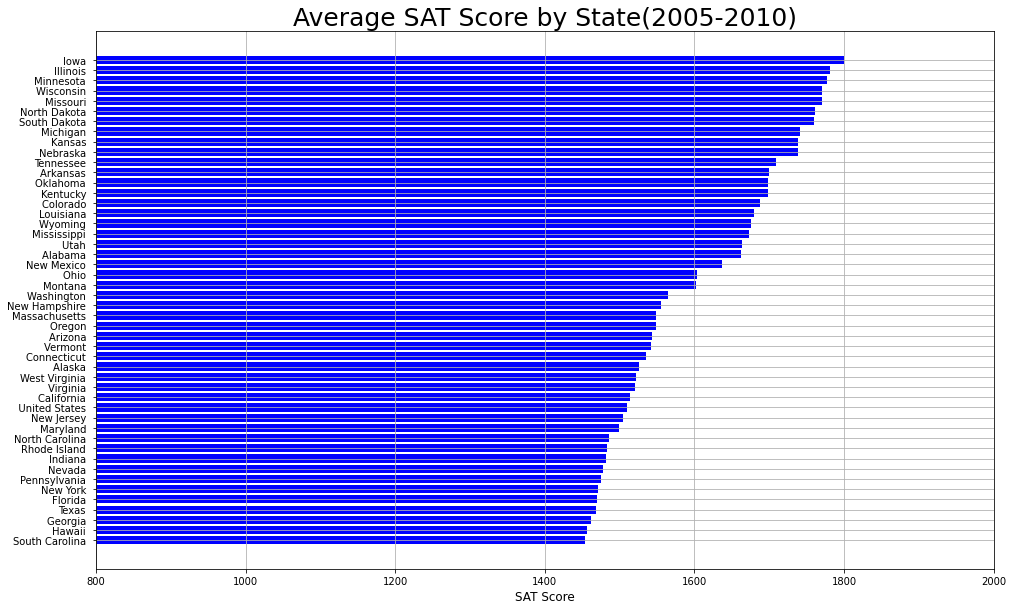

In [11]:
#Bar graph for first 6 years
x = df['States']

fig, ax = plt.subplots(figsize=(14,8))
ax.barh(x, df['Average Over 6 Years'], color='blue')

ax.grid(linestyle='-')
plt.tight_layout()
ax.set_xlim(800, 2000)
ax.set_title('Average SAT Score by State(2005-2010)', fontsize=25)
plt.xlabel('SAT Score', fontsize=12)

### 2011-2015 SAT Total Score for each State: 

In [12]:
#Average total score 2011-2015 to be plotted
merge_ = [sat_2011[['State', 'SAT Total Score']], sat_2012[['State', 'SAT Total Score']], sat_2013[['State', 'SAT Total Score']], 
            sat_2014[['State', 'SAT Total Score']], sat_2015[['State', 'SAT Total Score']]]

In [12]:
#Merging dataframes together
df2 = reduce(lambda x, y: pd.merge(x,y, on='State', how='inner'), merge_)
df2.columns = ['States', '2011 SAT Scores', '2012 SAT Scores', '2013 SAT Scores', '2014 SAT Scores', '2015 SAT Scores']

In [12]:
#Add average over 5 years column
df2['Average Over 5 Years'] = df2.drop('States', axis=1).apply(lambda x: x.mean(), axis=1)
df2.sort_values(['Average Over 5 Years'], axis=0, ascending=True, inplace=True)

Text(0.5, 51.0, 'SAT Score')

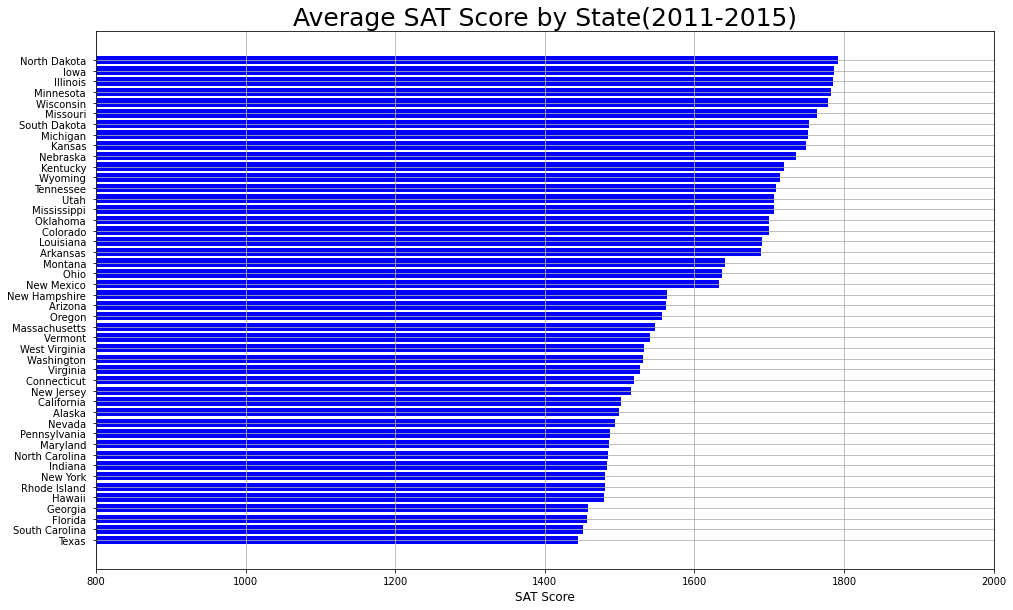

In [12]:
#Plotting
x = df2['States']

fig, ax = plt.subplots(figsize=(14,8))
ax.barh(x, df2['Average Over 5 Years'], color='blue')

ax.grid(linestyle='-')
plt.tight_layout()
ax.set_xlim(800, 2000)
ax.set_title('Average SAT Score by State(2011-2015)', fontsize=25)
plt.xlabel('SAT Score', fontsize=12)

In [13]:
#Curiousity: See which States held their top 10 status.
top_10_first_6_years = df[['States', 'Average Over 6 Years']].tail(10)
top_10_last_5_years = df2[['States', 'Average Over 5 Years']].tail(10)

In [13]:
#The States that were in the top 10 in 2005-2010 that held their top 10 spot in 2011-2015

reoccuring = top_10_first_6_years.merge(top_10_last_5_years, on='States', how='inner')
reoccuring.columns = ['States', 'Average Score(2005-2010)', 'Average Score(2011-2015)']
reoccuring

,States,Average Score(2005-2010),Average Score(2011-2015)
0,Nebraska,1738.000000,1736.4
1,Kansas,1738.833333,1749.8
2,Michigan,1740.833333,1752.2
3,South Dakota,1759.500000,1752.6
4,North Dakota,1760.666667,1791.8
5,Missouri,1770.166667,1764.2
6,Wisconsin,1770.333333,1779.0
7,Minnesota,1777.666667,1782.8
8,Illinois,1780.833333,1785.4
9,Iowa,1799.666667,1787.0


### Statistical Analysis

In [14]:
test = df.iloc[:,1:-1].values
test2 = df2.iloc[:, 1:-1].values
sample1 = np.random.choice(test.flatten(), len(test))
sample2 = np.random.choice(test2.flatten(), len(test2))

#Scatter Plot
first_df = df.drop(['Average Over 6 Years'], axis=1)
df_plot = [first_df['2005 SAT Scores'], first_df['2006 SAT Scores'], first_df['2007 SAT Scores'],
             first_df['2008 SAT Scores'], first_df['2009 SAT Scores'], first_df['2010 SAT Scores']]

second_df = df2.drop(['Average Over 5 Years'], axis=1)
df2_plot = [second_df['2011 SAT Scores'], second_df['2012 SAT Scores'], second_df['2013 SAT Scores'],
       second_df['2014 SAT Scores'], second_df['2015 SAT Scores']]


[Text(0, 0, 'a'), Text(0, 0, 'b')]

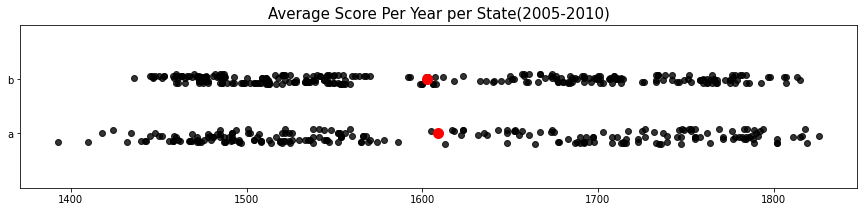

In [15]:

fig, ax = plt.subplots(figsize=(15,3))
jitter = np.random.uniform(-0.2, 0.1, size=second_df['2011 SAT Scores'].shape)
jitter1 = np.random.uniform(0.9, 1.1, size=first_df['2005 SAT Scores'].shape)

for i in df2_plot:
    ax.scatter(i, jitter, color='k', alpha=0.8)
ax.scatter(test2.mean(), 0, color='red', s=100)

for i in df_plot:
    ax.scatter(i, jitter1, color='k', alpha=0.8)
ax.set_ylim(-1,2)
ax.set_title('Average Score Per Year per State(2005-2010)', fontsize=15)
ax.scatter(test.mean(), 1, color='red', s=100)
ax.set_yticks([0,1])
ax.set_yticklabels(["a", 'b'])

In [16]:
#Null: There is no difference in the average SAT scores of 2005-2010 and the average SAT scores of 2011-2015


In [17]:
def count_winning_pairs(sample_1, sample_2):
    n_total_wins = 0
    for x in sample_1:
        n_wins = np.sum(x > sample_2) + 0.5*np.sum(x == sample_2)
        n_total_wins += n_wins
    return n_total_wins

In [18]:
old_wins = count_winning_pairs(sample1, sample2)
new_wins = count_winning_pairs(sample2, sample1)
print(old_wins)
print(new_wins)

1118.0
1090.0


In [19]:
res = stats.mannwhitneyu(sample1, sample2, alternative='greater')
print(f'p-value for 2005-2010 > 2011-2015: {res.pvalue}')

p-value for 2005-2010 > 2011-2015: 0.45933297312648985


In [20]:
df

,States,2005 SAT Scores,2006 SAT Scores,2007 SAT Scores,2008 SAT Scores,2009 SAT Scores,2010 SAT Scores,Average Over 6 Years
37,South Carolina,1465.0,1459.0,1461.0,1452.0,1447.0,1436.0,1453.333333
10,Hawaii,1463.0,1463.0,1453.0,1450.0,1458.0,1448.0,1455.833333
9,Georgia,1477.0,1472.0,1466.0,1460.0,1453.0,1445.0,1462.166667
40,Texas,1484.0,1481.0,1473.0,1467.0,1462.0,1446.0,1468.833333
8,Florida,1473.0,1472.0,1474.0,1475.0,1473.0,1447.0,1469.000000
29,New York,1486.0,1478.0,1473.0,1465.0,1461.0,1460.0,1470.500000
35,Pennsylvania,1476.0,1474.0,1478.0,1477.0,1473.0,1473.0,1475.166667
25,Nevada,1487.0,1486.0,1482.0,1485.0,1470.0,1460.0,1478.333333
12,Indiana,1493.0,1487.0,1485.0,1483.0,1476.0,1469.0,1482.166667
36,Rhode Island,1487.0,1486.0,1486.0,1488.0,1477.0,1477.0,1483.500000
